In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from AdvancedAnalytics.ReplaceImputeEncode import DT
from AdvancedAnalytics.ReplaceImputeEncode import ReplaceImputeEncode
from unidip import UniDip

%matplotlib inline

In [81]:
df=pd.read_excel(r"C:\Users\sd4be\Downloads\diamondswmissing.xlsx")

In [83]:
df.drop('obs',inplace=True,axis=1)

In [21]:
df.reset_index().drop('index',inplace=True,axis=1)

### part 1) Summarize data

In [84]:
print("the shape fo data:{}\n".format(df.shape))
print("feature types \n",df.dtypes.value_counts())
is_null=df.isnull().sum()
print("\null column and its counts:\n",is_null[is_null>0].sort_values(ascending=False))

the shape fo data:(5394, 10)

feature types 
 float64    6
object     3
int64      1
dtype: int64

ull column and its counts:
 Carat      556
cut        286
table      182
depth      181
y          174
clarity    169
z          159
x          155
color      154
dtype: int64


###  <span style="color:blue">Comments>></style>

Almost all the columns have missing values and each count is considerably higher than what I have thought before. In this case, we can come out with two solutions to manage missing entries. 


First, drop the columns whose frequency of missing data is higher than the threshold set.  This option would be our priority to take if we had a great number of columns.  Because we have only six columns, dropping could lead to a serious flaw in our modeling.  Also, without much knowledge on the determinants of the price of the diamond,  the carat is known to contribute to the explanation of variability of the price.

Second, experiment on the data set with a different number of imputation techniques and pick the one that gives the best performance to the rest. 
In this project,  we will try out three different imputation methods,imputation means, KNN imputation, and imputation iterative. 

### part 2) Imputing Data

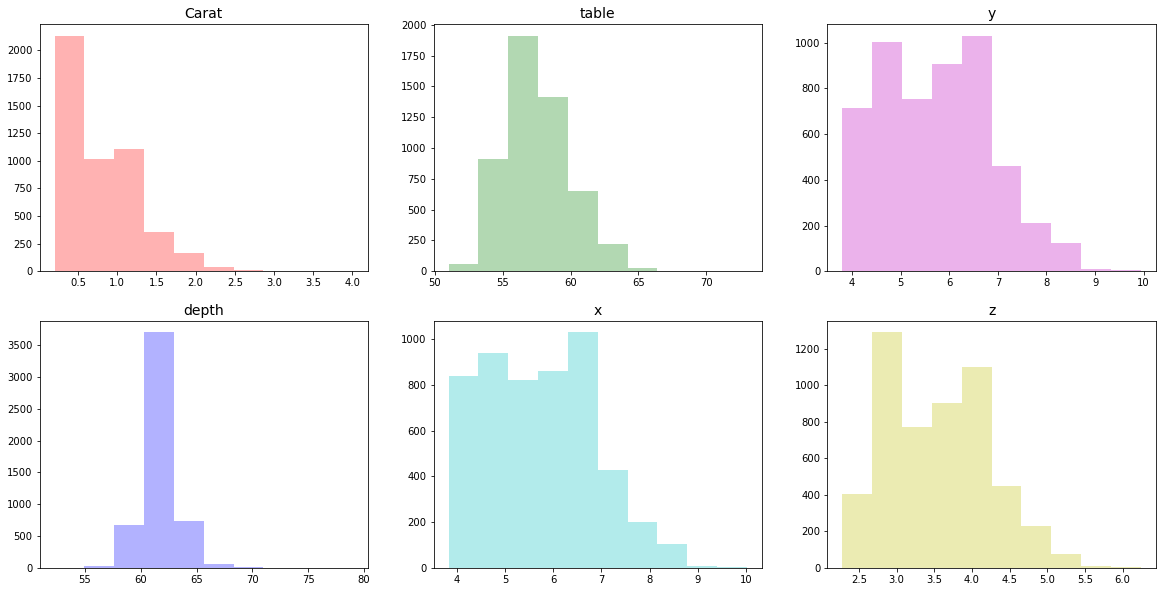

In [85]:
fig,axes=plt.subplots(2,3,figsize=(20,10))
quantitativeCols=df.describe().columns[1:].to_list()
colors={0:"r",1:"b",2:"g",3:'c',4:"m",5:'y'}
for index,value in enumerate(quantitativeCols):
    row,col=index%2,index//2
    axes[row][col].hist(df.loc[:,value],color=colors[index],alpha=0.3)
    axes[row][col].set_title(value,fontsize=14)

In [4]:
data_map={
    'Carat':[DT.Interval,(0.2,5.5)],
    'table':[DT.Interval,(40,65)],
    'depth':[DT.Interval,(57.5,68)],
    'x':[DT.Interval,(0,9)],
    'y':[DT.Interval,(0,10)],
    'z':[DT.Interval,(0,6)],
    'cut':[DT.Nominal,('Ideal', 'Premium', 'Good', 'Very Good', 'Fair')],
    'color':[DT.Nominal,('E', 'I', 'J', 'H', 'F', 'G', 'D')],
    'clarity':[DT.Nominal,('SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF')]}

rie=ReplaceImputeEncode(data_map=data_map)
encoded_df=rie.fit_transform(df.drop('price',axis=1))



In [3]:
# print("After imputation")
# encoded_df.isnull().sum()

Now, we need to bring back the price column to the imputed table.

In [27]:
df_imputed=pd.concat([encoded_df,df.loc[:,'price']],axis=1)

In [28]:
df_imputed.head()

,Carat,table,depth,x,y,z,cut,color,clarity,price
0,0.798309,55.0,61.50000,3.95,3.980000,2.430000,Ideal,E,SI2,326
1,0.210000,61.0,59.80000,3.89,3.840000,2.310000,Premium,E,SI1,326
2,0.230000,65.0,61.76786,4.05,4.070000,2.310000,Good,E,VS1,327
3,0.290000,58.0,62.40000,4.20,5.734447,2.630000,Premium,I,VS2,334
4,0.310000,58.0,63.30000,4.34,4.350000,3.537891,Good,J,SI2,335


### Part 3) Data Trasfromation

(array([25335.,  9328.,  7393.,  3878.,  2364.,  1745.,  1306.,  1002.,
          863.,   726.]),
 array([  326. ,  2175.7,  4025.4,  5875.1,  7724.8,  9574.5, 11424.2,
        13273.9, 15123.6, 16973.3, 18823. ]),
 <BarContainer object of 10 artists>)

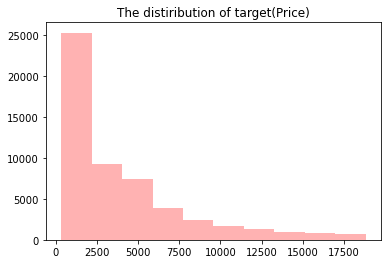

In [149]:
plt.title("The distiribution of target(Price)")
plt.hist(df_imputed.price,color='r',alpha=0.3)

###  <span style="color:blue">Comments>></style>

Assuming that there exists a relationship between dependent and independent variables, the performance level of the regression model should vary depending on the distribution of factors that contribute to the explanation of the variability of the target.  Especially, the bell-shaped distribution of data is always preferable because the asymmetrical shape could lead to lower ability of prediction.  Therefore, it is a must to examine and check if each target and feature approximately follow the normal distribution.



The distribution of our target is highly asymmetric and skewed to the right. As I previously mentioned, this may be one of the factors seriously debasing the power of prediction. According to many research papers, log transformation is known to be the best strategy to reduce the sickness of data. Please, note that the data trasfromation to approximate the normal distirubiton is not strictly stated under the assumptions of the regression model. Still, it is worth trying out for producing the better result. 

Text(0.5, 1.0, 'Log transformation of price ')

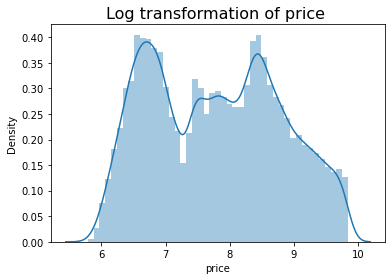

In [155]:
sns.distplot(np.log1p(df_imputed.price))
plt.title("Log transformation of price ",fontsize=16)

Surprisingly, the log transformation results in multimodal distributions where more than few peacks close to each other. This gives us some glimpse that the distribution of price is not following unimodal. To validate our skepticism, we need to run a statistical test for uniform distribution. 

In [247]:
#data=df_imputed.copy()
import pickle
with open("imputed_data.pickle",'rb') as f:
    df=pickle.load(f)
    

index=np.random.randint(0,len(df),int(len(df)*0.2))

In [249]:
df=df.loc[index,:]
df.head()
df.reset_index().drop('index',inplace=True,axis=1)

### Part 4)  Statistical Tests for Unimodal Distributions (DIP test) & Clustering(K-mean)


In [226]:
from unidip import UniDip
import unidip.dip as dip

In [228]:
data = np.msort(df.price)
print(dip.diptst(data))
intervals = UniDip(data).run()
print(intervals)

### <span style="color:blue">Comments</span>

The second value indicateswhether our data is unimodal. But the p-value which is much less then 0.05,which gives us a resoable ground to reject the null hypothesis,"our price is followiing the unimodal distribution". Because we do not have a separate feature to represent the group information for each record, we need to run a simple unsupervised learning algorithm to see if the grouping is feasible. 

In [238]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score



def format_features(df):
    features=['cut','color','clarity']
    for feature in features:
        le=LabelEncoder()
        le=le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    return df


def data_reduction(data):
    data=data.drop(['cut','color','clarity'],axis=1)
    pca=PCA(n_components=2)
    trans=pca.fit_transform(data)
    return trans
    

data=format_features(df)
tran=data_reduction(data)

model=KMeans(n_clusters=2,random_state=0)
kmean_label=model.fit(data).predict(data)

Text(0, 0.5, 'component 2')

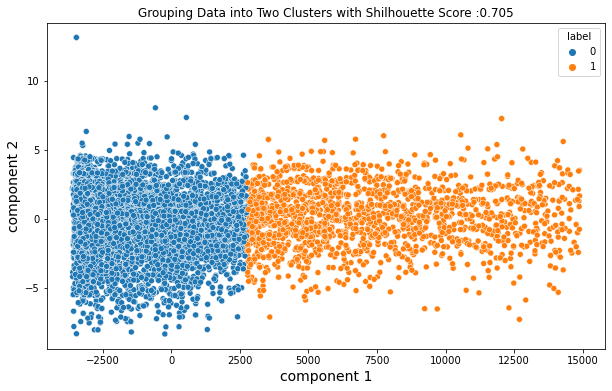

In [239]:
temp=pd.concat([pd.DataFrame(tran),pd.Series(kmean_label)],axis=1)
temp.columns=['x','y','label']
score=silhouette_score(tran,kmean_label)
fig,ax=plt.subplots(figsize=(10,6),nrows=1,ncols=1)
sns.scatterplot(x='x',y='y',hue='label',data=temp)
ax.set_title("Grouping Data into Two Clusters with Shilhouette Score :{}".format(round(score,3)))
ax.set_xlabel("component 1",fontsize=14)
ax.set_ylabel("component 2",fontsize=14)

Not only does Visualization give us a clear cut to group data into two, but the silhouette score is also high enough to make our clustering reasonable and valid. 

### Part5) Modeling

In [262]:
from sklearn.model_selection import GridSearchCV

def best_params(model,params):
    

,Carat,table,depth,x,y,z,cut,color,clarity,price
0,0.300000,59.0,61.9,4.27,5.734447,2.65,Ideal,E,VVS2,766
1,0.300000,59.0,61.9,4.27,5.734447,2.65,Ideal,E,VVS2,766
2,1.020000,57.0,62.2,6.45,6.410000,4.00,Ideal,E,SI1,5655
3,0.300000,57.0,60.9,4.35,4.320000,2.64,Ideal,G,SI1,878
4,0.798309,61.0,60.5,5.43,5.500000,3.31,Good,F,VS1,1861


,Carat,table,depth,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.300000,59.0,61.9,4.27,5.734447,2.65,766,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0.300000,59.0,61.9,4.27,5.734447,2.65,766,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1.020000,57.0,62.2,6.45,6.410000,4.00,5655,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0.300000,57.0,60.9,4.35,4.320000,2.64,878,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.798309,61.0,60.5,5.43,5.500000,3.31,1861,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12943,1.080000,56.0,62.1,6.59,6.560000,4.08,5839,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12944,0.580000,57.0,61.9,5.37,5.330000,3.31,1984,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12945,0.520000,57.0,61.9,5.14,5.170000,3.19,1822,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12946,1.510000,60.0,62.4,7.34,7.270000,4.56,10939,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [282]:
data=pd.read_csv(r"C:\Users\sd4be\Downloads\diamond_2.csv")

In [283]:
if 'Unnamed: 0' in data.columns:
    data.drop('Unnamed: 0',axis=1,inplace=True)

In [295]:
data=pd.get_dummies(data.rename({'Carat':'carat'},axis=1))

In [296]:
data.to_csv(r"C:\Users\sd4be\Downloads\diamond_3.csv")

In [308]:
data=pd.read_csv(r"C:\Users\sd4be\Downloads\diamond_3.csv")
if 'Unnamed: 0' in data.columns:
        data.drop('Unnamed: 0',axis=1,inplace=True)

In [309]:
 X_features,y_target=data.drop("price",axis=1),data.loc[:,"price"]

In [313]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
model_name,params=Ridge(),[0.05,0.1,1,5,8,10,12,15,20]

In [314]:
 grid_model=GridSearchCV(model_name,param_grid=params,scoring='neg_mean_squared_error',cv=5)

AttributeError: 'float' object has no attribute 'items'